<a href="https://colab.research.google.com/github/johnreyes96/artificial-vision/blob/master/src/main/python/QualityMeat_Method_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [60]:
# importing modules
import cv2
import numpy as np
import os
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from PIL import Image
import requests
import matplotlib.pyplot as plt
from io import BytesIO

In [62]:
train_x = []
train_y = []
test_x = []
test_y = []

# the class of each image file can be extracted using the file name
# to do so, we can split the filename using '-' and take the item in the 0th index

file_name = os.listdir('/content/drive/MyDrive/vision_artificial/images/meats/train/')
names = [i.split('-')[0] for i in file_name]
set(names)

# performing label encoding
class_label_encoding = {
    'SPOILED': 0,
    'FRESH': 1
}

train_dir = '/content/drive/MyDrive/vision_artificial/images/meats/train/'
for folder in os.listdir(train_dir):
    for file_name in os.listdir(train_dir+folder):
        class_name = file_name.split('-')[0]
        img = cv2.imread(train_dir+folder+'/'+file_name).astype('float32') # read the image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to rgb format
        img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA) # resize the image
        img /= 255. # normalising pixel values
        train_x.append(img)
        train_y.append(class_label_encoding[class_name])


val_dir = '/content/drive/MyDrive/vision_artificial/images/meats/valid/'
for folder in os.listdir(val_dir):
    for file_name in os.listdir(val_dir+folder):
        class_name = file_name.split('-')[0]
        img = cv2.imread(val_dir+folder+'/'+file_name).astype('float32') # read the colour image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to rgb format
        img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA) # resize the image
        img /= 255. # normalising pixel values
        test_x.append(img)
        test_y.append(class_label_encoding[class_name])

In [63]:
print('shape of train x:', end=' ')
print(np.asarray(train_x).shape)
print('len of train y: '+ str(len(train_y)))
print('shape of test x:', end=' ')
print(np.asarray(test_x).shape)
print('len of test y: '+ str(len(test_y)))


# performing train test split with stratify enabled to maintain the class distribution
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.3, random_state=42, stratify=train_y)

# free up memory
del train_x
del train_y

# performing one hot encoding and concerting list to numpy array before training
x_train = np.array(x_train)
x_val = np.array(x_val)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)


model = Sequential()

model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3))) # each image shape - 416x416x3
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Dropout(0.25))

model.add(layers.Flatten())

model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2,'softmax')) # 3 classes

model.compile('Adam','categorical_crossentropy',['accuracy'])

model.summary()

shape of train x: (20, 128, 128, 3)
len of train y: 20
shape of test x: (20, 128, 128, 3)
len of test y: 20
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 conv2d_7 (Conv2D)           (None, 58, 58, 128)       73856     
                                                                 
 max_pooling

In [64]:
# perform data augmentation
data_generator = ImageDataGenerator(rotation_range=15, zoom_range=0.1, vertical_flip=True,
                                    width_shift_range=0.1, height_shift_range=0.1)

history = model.fit(data_generator.flow(x_train,y_train,batch_size=128),
                    validation_data=data_generator.flow(x_val, y_val, batch_size=32),
                    epochs=20,callbacks=[EarlyStopping(patience=8,restore_best_weights=True)])

Epoch 1/20
1/1 [==============================] - 4s 4s/step - loss: 0.6785 - accuracy: 0.5714 - val_loss: 0.7789 - val_accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 1.6687 - accuracy: 0.6429 - val_loss: 4.6252 - val_accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 3.4289 - accuracy: 0.5000 - val_loss: 0.6566 - val_accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 0.7833 - accuracy: 0.5000 - val_loss: 0.7452 - val_accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 0.7302 - accuracy: 0.5714 - val_loss: 0.7128 - val_accuracy: 0.5000
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 0.8320 - accuracy: 0.2857 - val_loss: 0.7001 - val_accuracy: 0.5000
Epoch 7/20
1/1 [==============================] - 2s 2s/step - loss: 0.6822 - accuracy: 0.5000 - val_loss: 0.6847 - val_accuracy: 0.5000
Epoch 8/20
1/1 [=========================

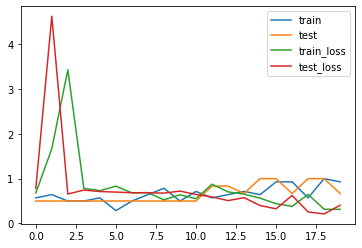

1/1 [==============================] - 1s 663ms/step - loss: 0.4127 - accuracy: 0.7500
Testing accuracy on unseen data: 75.0
Testing loss on unseen data: 0.413
1/1 [==============================] - 0s 142ms/step
La predicción es : SPOILED


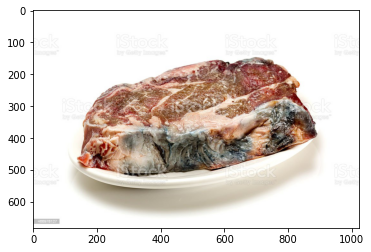

['SPOILED', 'FRESH']
[[0.9856235  0.01437654]]


In [65]:
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.plot(history.history['loss'], label='train_loss')
pyplot.plot(history.history['val_loss'], label='test_loss')
pyplot.legend()
pyplot.show()


loss, acc = model.evaluate(np.array(test_x), to_categorical(test_y))
print('Testing accuracy on unseen data:', round(acc*100,3))
print('Testing loss on unseen data:', round(loss,3))


model.save('trained_model.h5')
model1 = tf.keras.models.load_model("trained_model.h5")

# Obtiene la imagen de internet y la procesa
def get_and_process(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img1 = img
    """Resize img to proper for feed model."""
    img = img.resize((128,128))
    """Convert img to numpy array,rescale it,expand dims and check vertically."""
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = x / 255.0 
    x = np.expand_dims(x,axis = 0)
    img_tensor = np.vstack([x])
    return img1,img_tensor


# FINAL : Predecir imagen
url = "https://media.istockphoto.com/photos/spoiled-steak-picture-id466978127"
img1,test_img = get_and_process(url)

pred = model1.predict(test_img)
classes = list(class_label_encoding.keys())
print(f"La predicción es : {classes[np.argmax(pred)]}")
plt.imshow(img1)
plt.show()

print(classes)
print(pred)

# https://www.kaggle.com/code/kaushikjegannathan/meat-freshness-image-classification/notebook